In [1]:
import os 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.style
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import anndata
from scipy import stats

In [2]:
def adata2numpy(adata):
    if sparse.issparse(adata.X):
        return adata.X.A
    else:
        return adata.X

In [3]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=18)

In [4]:
def calc_R2(adata, cell_type_key, cell_type, n_genes=6998, conditions=None):
    if n_genes != adata.shape[1]:
        adata_cell = adata[adata.obs[cell_type_key] == cell_type]
        print(adata_cell.obs["condition"].unique().tolist())
        sc.tl.rank_genes_groups(adata_cell, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = adata_cell.uns["rank_genes_groups"]["names"][conditions["real_stim"]].tolist()[:n_genes//2] \
                   + adata_cell.uns["rank_genes_groups"]["names"][conditions["ctrl"]].tolist()[:n_genes//2]
        adata = adata[:, diff_genes]
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
    for i in range(100):
        pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.8 * pred_stim.shape[0]))
        real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.8 * real_stim.shape[0]))
        pred_stim_data = adata2numpy(pred_stim)
        real_stim_data = adata2numpy(real_stim)
        x = np.average(pred_stim_data[pred_stim_idx], axis=0)
        y = np.average(real_stim_data[real_stim_idx], axis=0)
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        r_values[0, i] = r_value ** 2
    return r_values.mean(), r_values.std()

In [5]:
def calc_R2_mean_var(adata, data_name, cell_types, n_genes):
    r2_means, r2_vars = [], []
    for cell_type in cell_types:
        conditions = {"ctrl": f"{cell_type}_ctrl" ,"real_stim": f"{cell_type}_real", "pred_stim": f"{cell_type}_pred"}
        r2_mean, r2_var = calc_R2(adata, data_name, cell_type, n_genes=n_genes, conditions=conditions)
        r2_means.append(r2_mean)
        r2_vars.append(r2_var)
    return r2_means, r2_vars

In [6]:
def dotplot(adata, gene_list, model_name):
    sc.set_figure_params(fontsize=14)
    sc.pl.dotplot(adata, var_names=gene_list, groupby="condition", show=True)
    # os.rename(src=os.path.join(path_to_save, "dotplot.pdf"), dst=os.path.join(path_to_save, "Fig2f_dotplot.pdf"))

In [7]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=False, legend=False, offset=0.375, data_name = 'pbmc'):
    colors = ['#56B4E9', '#E69F00']
    plt.close("all")
#     import matplotlib
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=30)
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
    plt.figure(figsize=(12, 10))
    ax = plt.gca()
#     g = sns.catplot(x=cat, y=val, hue=subcat, data=df, kind='bar', palette="muted", height=6, legend=False)
#     g.despine(left=True)
#     plt.yticks(np.arange(0, 1.2, 0.2))
#     g.set_xticklabels(rotation=90)
#     g.set_xlabels("")
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = ax.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values, color = colors[i])
        a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
#         print(a.shape)
#         dfc=pd.DataFrame({'x': x_pos + i/1.25, 'y': a[0]})
        ax.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    plt.title(f"{data_name}_grouped_boxplot")
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=25)
    plt.xticks(x_pos+offset, u, rotation=90)
    ax.grid(False)
    ax.spines["left"].set_color("k")
    ax.spines["top"].set_color("k")
    ax.spines["bottom"].set_color("k")
    ax.spines["right"].set_color("k")
    if legend:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    # plt.savefig(os.path.join('figures','grouped_boxplot', filename), transparent=True, dpi=300)
    # print("saved at:" + os.path.join('figures','grouped_boxplot', filename))
    plt.show()

In [10]:
def draw_csv(cell_types, data_name, keys):
    # train = sc.read('../data/train_' + model_name + '.h5ad')
    stim_key, ctrl_key, pred_key, cell_type_key = keys
    now = []
    for name in cell_types:
        adata = sc.read(f"../{data_name}/model_{name}/result.h5ad")
        stim = adata[adata.obs["condition"] == stim_key]
        stim.obs['condition'] = f"{name}_real"

        # print(stim.obs['condition'])
        
        ctrl = adata[adata.obs["condition"] == ctrl_key]
        ctrl.obs['condition'] = f"{name}_ctrl"
        
        # print(ctrl.obs['condition'])

        pred = adata[adata.obs["condition"] == pred_key]
        pred.obs['condition'] = f"{name}_pred"

        # print(pred.obs['condition'])
        
        new_data = anndata.concat([stim, ctrl, pred])
        now.append(new_data)

    now = anndata.concat(now)

    # now.var_names = train.var_names

    print("finish pre data")

    r2_top100_means, r2_top100_vars = calc_R2_mean_var(now, cell_type_key, cell_types=cell_types, n_genes=100)

    print("finish top 100")

    r2_all_means, r2_all_vars = calc_R2_mean_var(now, cell_type_key, cell_types=cell_types, n_genes=now.shape[1])

    print("finish all genes")

    all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
    all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
    all_types = ["top 100 DEGs"] * len(r2_top100_means) + ["all genes"] * len(r2_top100_means)
    cell_types_x = 2 * cell_types
    print("draw_df:")
    df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})

    # df.to_csv(os.path.join('../supervise_2enc_spaperb_saved_one_loss', data_name + '.csv'))
    # print("saved at: ", os.path.join('../supervise_2enc_spaperb_saved_one_loss', data_name + '.csv'))

    all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
    all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
    all_types = ["top 100 DEGs"] * 7 + ["all genes"] * 7
    cell_types_x = 2 * cell_types
    df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})
    # print(df[df["Type"] == "top 100 DEGs"].mean())
    # print(df[df["Type"] == "all genes"].mean())
    sns.set()
    grouped_barplot(df, "Cell Types", "Type", "R^2 Means", "R^2 Stddevs", legend=True, filename=data_name + "_celltypes_barplots.pdf", data_name = data_name)
    # gene_list = ["CD3D", "CCL5", "GNLY", "CD79A", "FCGR3A", "S100A9", "HLA-DQA1", "ISG15", "IFI6", "IFIT1", "CXCL10", "CXCL11", "APOBEC3A", "DEFB1", "CCL8", "TARBP1"]
#     if model_name == 'pbmc':
#         dotplot(now, gene_list, model_name)

/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctrl.obs['condition'] = f"{name}_ctrl"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pred.obs['condition'] = f"{name}_pred"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:13: ImplicitModificatio

finish pre data
['B_real', 'B_ctrl', 'B_pred']
['CD4T_real', 'CD4T_ctrl', 'CD4T_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['CD8T_real', 'CD8T_ctrl', 'CD8T_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['CD14+Mono_real', 'CD14+Mono_ctrl', 'CD14+Mono_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['Dendritic_real', 'Dendritic_ctrl', 'Dendritic_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['FCGR3A+Mono_real', 'FCGR3A+Mono_ctrl', 'FCGR3A+Mono_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['NK_real', 'NK_ctrl', 'NK_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


finish top 100
finish all genes
draw_df:


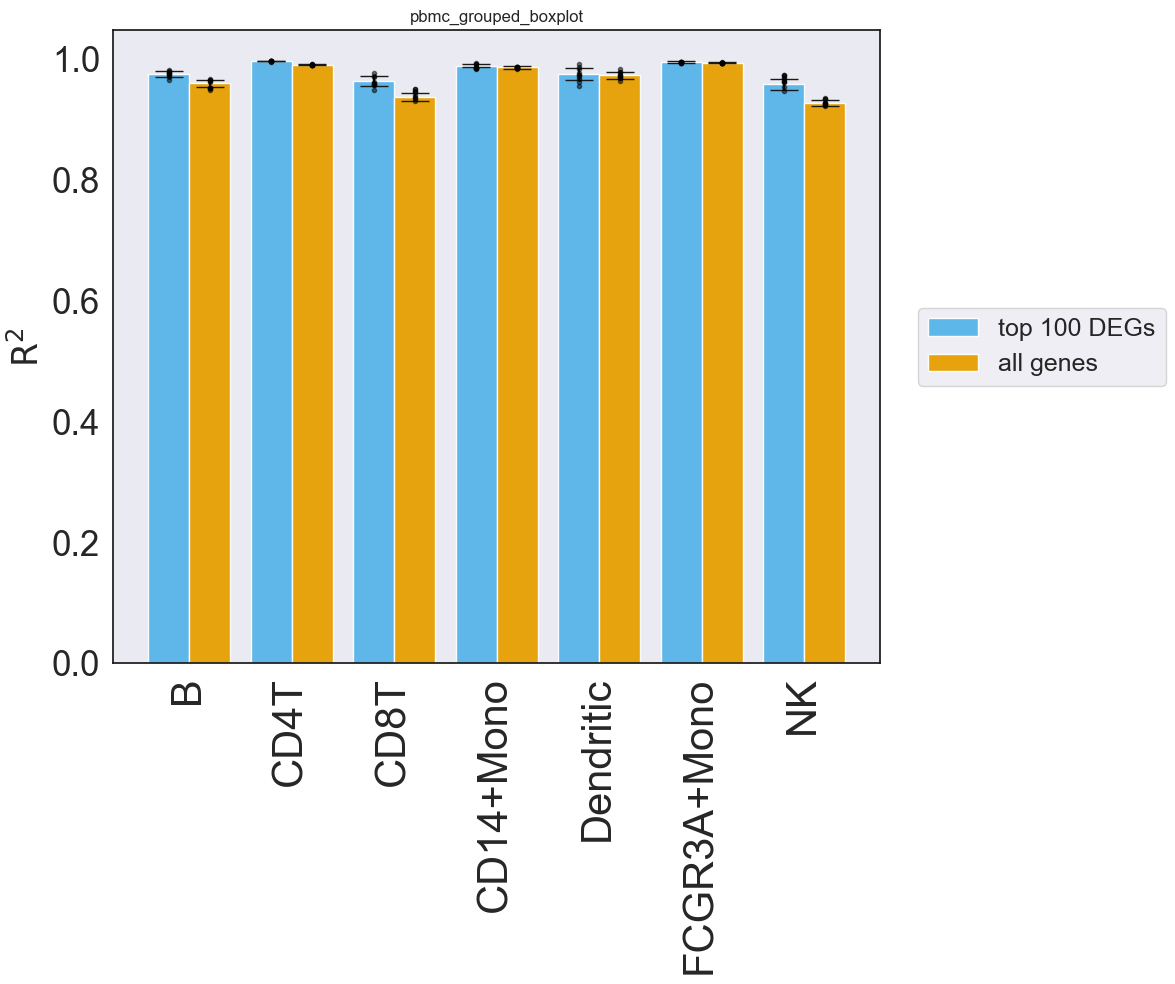

finish pbmc


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctrl.obs['condition'] = f"{name}_ctrl"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pred.obs['condition'] = f"{name}_pred"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:13: ImplicitModificatio

finish pre data
['Endocrine_real', 'Endocrine_ctrl', 'Endocrine_pred']
['Enterocyte_real', 'Enterocyte_ctrl', 'Enterocyte_pred']
['Enterocyte.Progenitor_real', 'Enterocyte.Progenitor_ctrl', 'Enterocyte.Progenitor_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['Goblet_real', 'Goblet_ctrl', 'Goblet_pred']
['Stem_real', 'Stem_ctrl', 'Stem_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['TA_real', 'TA_ctrl', 'TA_pred']
['TA.Early_real', 'TA.Early_ctrl', 'TA.Early_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


finish top 100
finish all genes
draw_df:


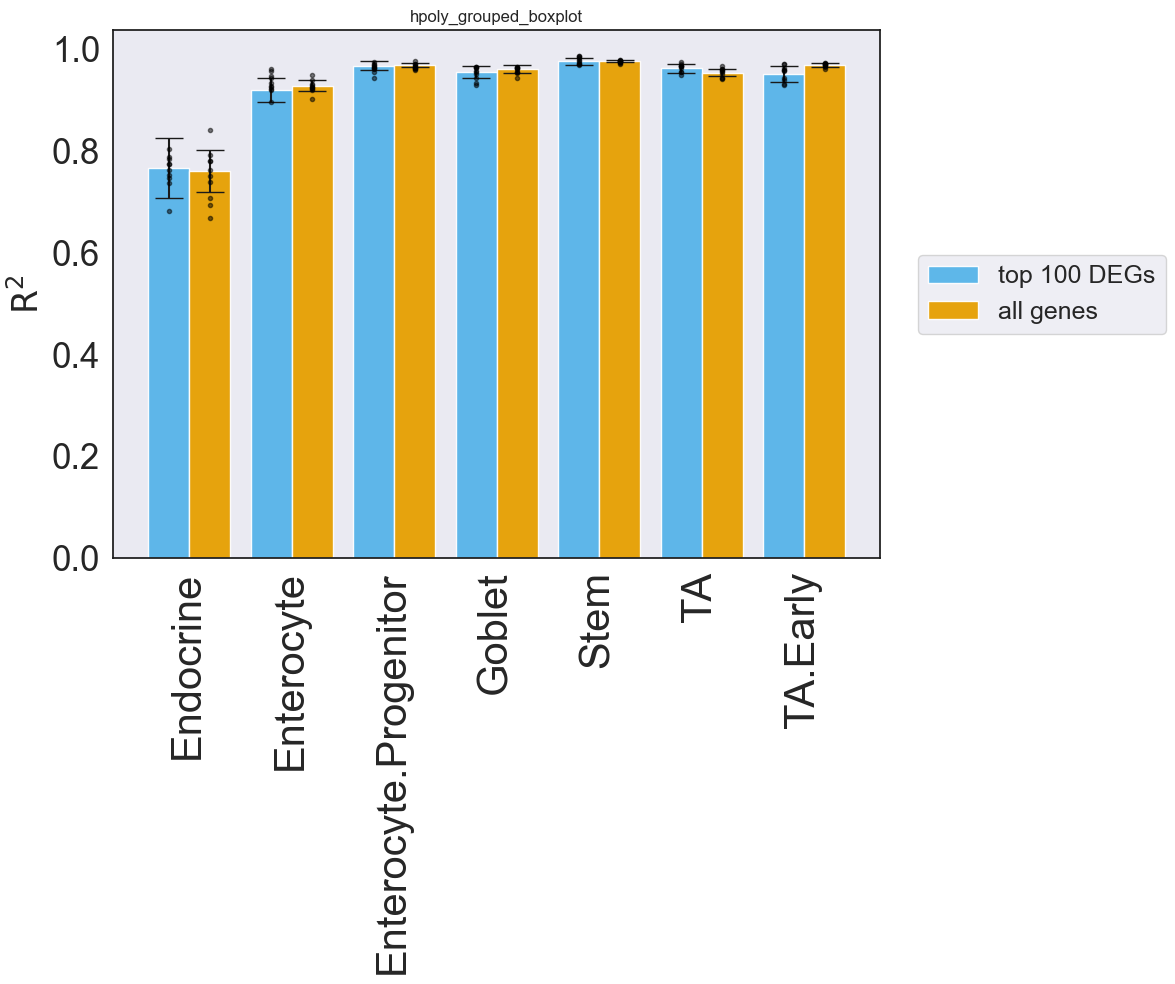

finish hpoly


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctrl.obs['condition'] = f"{name}_ctrl"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pred.obs['condition'] = f"{name}_pred"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_26893/2121603452.py:13: ImplicitModificatio

finish pre data
['B_real', 'B_ctrl', 'B_pred']
['CD4T_real', 'CD4T_ctrl', 'CD4T_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['CD8T_real', 'CD8T_ctrl', 'CD8T_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['CD14+Mono_real', 'CD14+Mono_ctrl', 'CD14+Mono_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['Dendritic_real', 'Dendritic_ctrl', 'Dendritic_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['FCGR3A+Mono_real', 'FCGR3A+Mono_ctrl', 'FCGR3A+Mono_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['NK_real', 'NK_ctrl', 'NK_pred']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


finish top 100
finish all genes
draw_df:


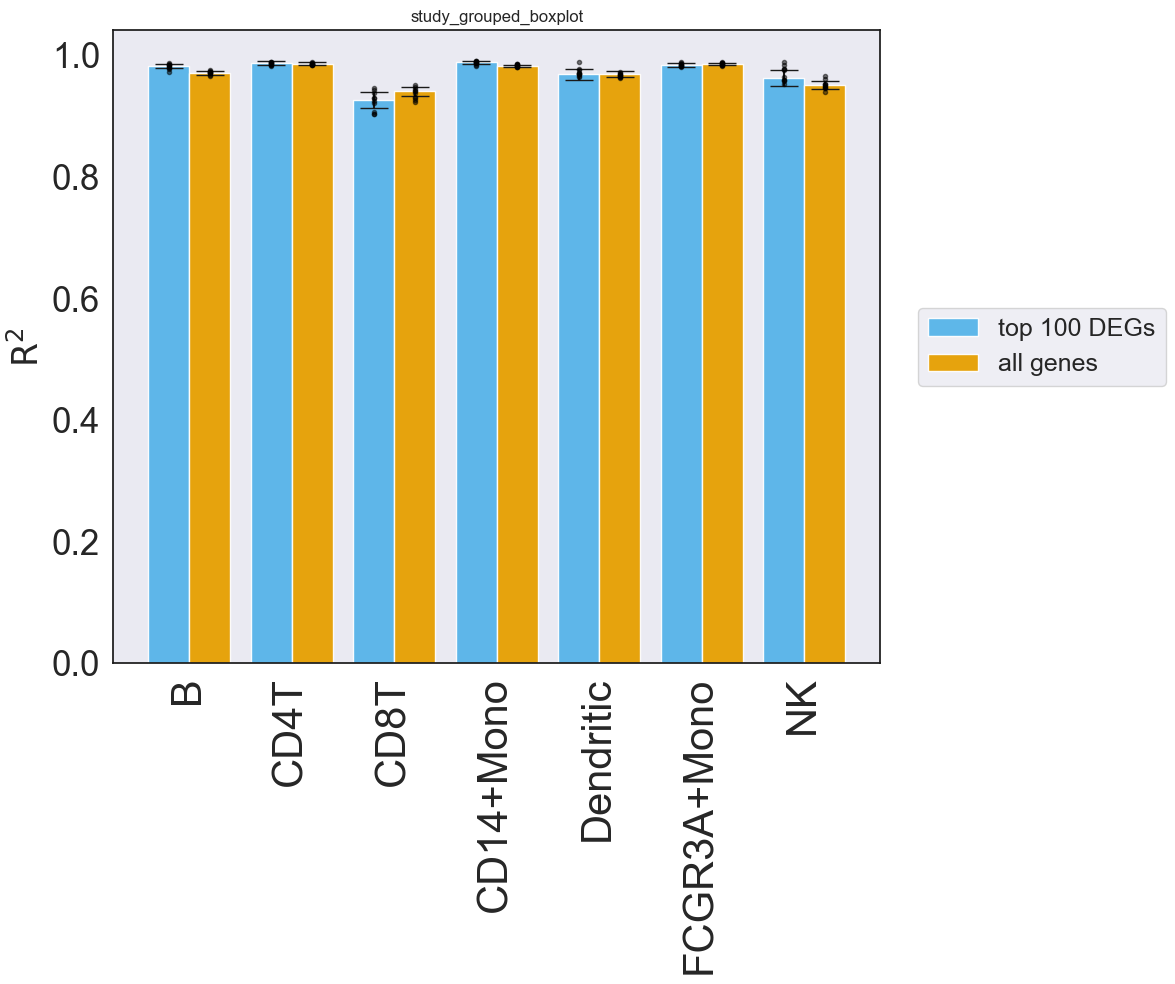

finish study


In [11]:
name_pbmc = ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK']
name_hpoly = ['Endocrine', 'Enterocyte', 'Enterocyte.Progenitor', 'Goblet', 'Stem', 'TA', 'TA.Early']
name_study = ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK']
key_pbmc = ['stimulated', 'control', 'pred', 'cell_type']
key_hpoly = ['Hpoly.Day10', 'Control', 'pred', 'cell_label']
key_study = ['stimulated', 'control', 'pred', 'cell_type']
draw_csv(name_pbmc, "pbmc", key_pbmc)
print("finish pbmc")
draw_csv(name_hpoly, 'hpoly', key_hpoly)
print("finish hpoly")
draw_csv(name_study, 'study', key_study)
print("finish study")